<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li></ul></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ моделей</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов.

**Входные данные:**

- Исторические данные: технические характеристики, комплектации и цены автомобилей:

https://code.s3.yandex.net/datasets/autos.csv 


**Признаки:**

`DateCrawled` — дата скачивания анкеты из базы

`VehicleType` — тип автомобильного кузова

`RegistrationYear` — год регистрации автомобиля

`Gearbox` — тип коробки передач

`Power` — мощность (л. с.)

`Model` — модель автомобиля

`Kilometer` — пробег (км)

`RegistrationMonth` — месяц регистрации автомобиля

`FuelType` — тип топлива

`Brand` — марка автомобиля

`Repaired` — была машина в ремонте или нет

`DateCreated` — дата создания анкеты

`NumberOfPictures` — количество фотографий автомобиля

`PostalCode` — почтовый индекс владельца анкеты (пользователя)

`LastSeen` — дата последней активности пользователя

**Целевой признак:**

`Price` — цена (евро)

**Условия задачи:**

- Заказчику важны:

    - качество предсказания;
    
    - скорость предсказания;

    - время обучения.

- Не ограничиваться градиентным бустингом. Попробовать более простые модели.

- Для оценки качества моделей применить метрику RMSE.

- Значение метрики RMSE должно быть меньше 2500.
        
**Цель исследования:**
        
- Построить модель для определения стоимости.

**Задачи:**

- Обучить разные модели, одна из которых — LightGBM

- Как минимум одна модель — не бустинг. 

- Для каждой модели попробовать разные гиперпараметры.

- Проанализировать время обучения, время предсказания и качество моделей.

- Опираясь на критерии, выбрать лучшую модель, проверить её качество на тестовой выборке.

**Этапы исследования:**

- Подготовка данных

- Обучение моделей

- Анализ моделей

- Общий вывод

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import OrdinalEncoder

import warnings
warnings.filterwarnings("ignore")

In [2]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
DateCrawled,354369,271174,2016-03-24 14:49:47,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,354369.0,NaN,NaN,NaN,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
VehicleType,316879,8,sedan,91457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RegistrationYear,354369.0,NaN,NaN,NaN,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Gearbox,334536,2,manual,268251,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Power,354369.0,NaN,NaN,NaN,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Model,334664,250,golf,29232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Kilometer,354369.0,NaN,NaN,NaN,128211.172535,37905.34153,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,NaN,NaN,NaN,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
FuelType,321474,7,petrol,216352,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.duplicated().sum()

4

Удалим дубликаты

In [7]:
df.drop_duplicates(inplace=True)

Удалим признаки, которые не понадобятся для обучения:

`DateCrawled` — дата скачивания анкеты из базы

`DateCreated` — дата создания анкеты

`NumberOfPictures` — количество фотографий автомобиля

`PostalCode` — почтовый индекс владельца анкеты (пользователя)

`LastSeen` — дата последней активности пользователя

In [8]:
df.NumberOfPictures.unique()

array([0])

In [9]:
df.drop(columns = ['DateCrawled', 'DateCreated', 'NumberOfPictures', 'LastSeen'], inplace=True)

Проверим пропуски

In [10]:
df.isna().sum()

Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
PostalCode               0
dtype: int64

Без знания модели определить стоимость будет очень сложно, поэтому строки с пропусками по этому признаку придется уделить.

In [11]:
df.dropna(subset=['Model'], inplace = True)

Пропуски в остальных категориальных признаках заменим на значение 'unknown'

In [12]:
df = df.fillna('unknown')
df.isna().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
PostalCode           0
dtype: int64

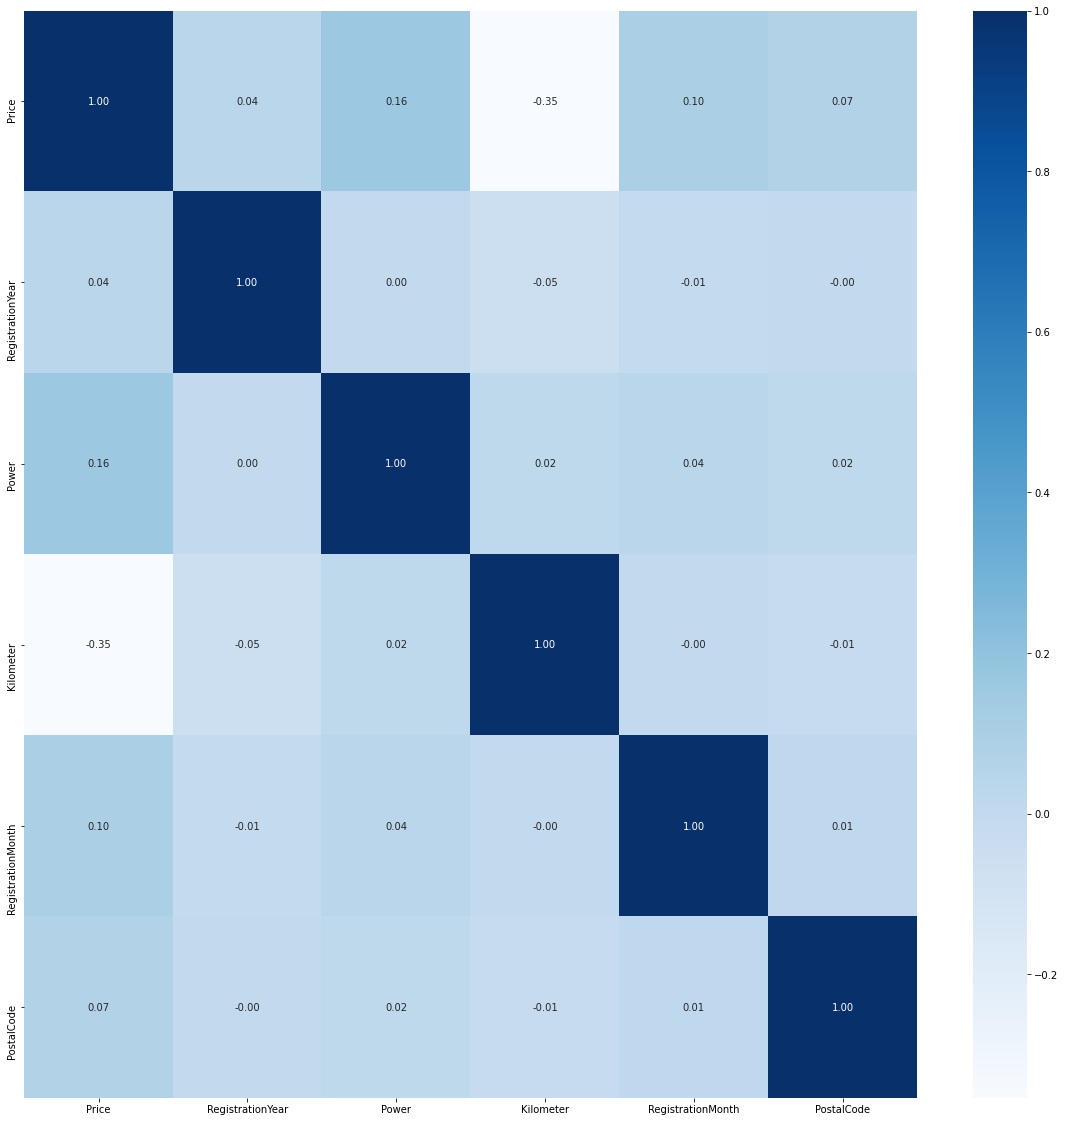

In [13]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), annot=True, cmap="Blues", fmt='.2f');

`Price`

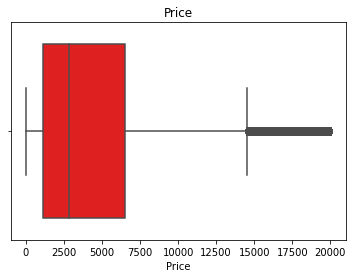

In [14]:
sns.boxplot(x=df['Price'], color='red')  
plt.title('Price');

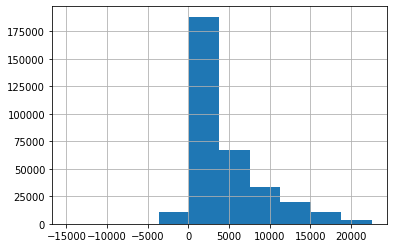

In [15]:
q1 = df.Price.quantile(0.25)
q3 = df.Price.quantile(0.75)
iqr = q3 - q1

df.Price.hist(bins=10, range=((q1-3*iqr), (q3+3*iqr)))
plt.show()

In [16]:
df['Price'].value_counts()

0        8588
500      5215
1500     5001
1200     4299
1000     4250
         ... 
3988        1
14227       1
11920       1
1429        1
8188        1
Name: Price, Length: 3670, dtype: int64

8588 значений с нулевой ценой.
Оставим значения 'price' диапазоне от q1=df.Price.quantile(0.04) и q3=df.Price.quantile(0.96)

In [17]:
df.Price.quantile(0.04)

150.0

In [18]:
df.Price.quantile(0.96)

15500.0

In [19]:
df_filtred = df.query('0 < Price <= 15500')

`RegistrationYear`

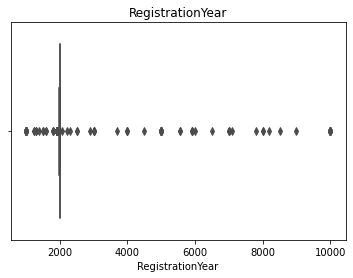

In [20]:
sns.boxplot(x=df_filtred['RegistrationYear'], color='red')  
plt.title('RegistrationYear');

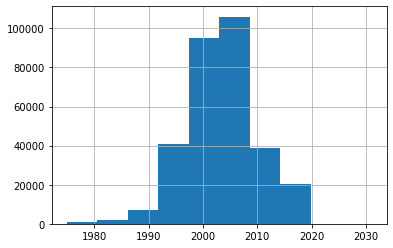

In [21]:
q1 = df_filtred.RegistrationYear.quantile(0.25)
q3 = df_filtred.RegistrationYear.quantile(0.75)
iqr = q3 - q1

df_filtred.RegistrationYear.hist(bins=10, range=((q1-3*iqr), (q3+3*iqr)))
plt.show()

In [22]:
df_filtred.RegistrationYear.quantile(0.01)

1983.0

Данные за 2016 год. Все, что выше - выбросы

In [24]:
df_filtred = df_filtred.query('1983 <= RegistrationYear <= 2016')

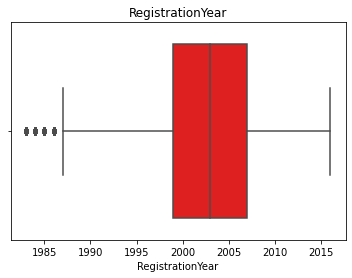

In [25]:
sns.boxplot(x=df_filtred['RegistrationYear'], color='red')  
plt.title('RegistrationYear');

`Power`

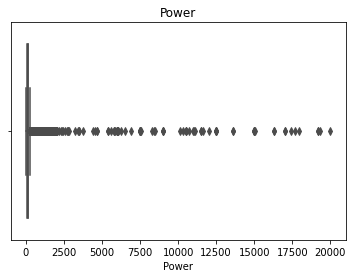

In [26]:
sns.boxplot(x=df_filtred['Power'], color='red')  
plt.title('Power');

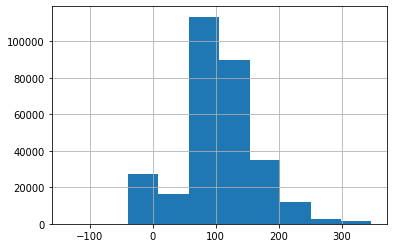

In [27]:
q1 = df_filtred.Power.quantile(0.25)
q3 = df_filtred.Power.quantile(0.75)
iqr = q3 - q1

df_filtred.Power.hist(bins=10, range=((q1-3*iqr), (q3+3*iqr)))
plt.show()

Очевидно некоторые пользователи указали мощность не в л.с. Экспертно, оставим адекватные значения от 50 до 300 л.с.

In [28]:
df_filtred = df_filtred.query('50 < Power <= 300')

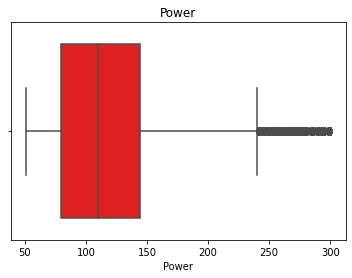

In [29]:
sns.boxplot(x=df_filtred['Power'], color='red')  
plt.title('Power');

Разделим на обучающую и тестовую выборки

In [31]:
features = df_filtred.drop(['Price'],axis=1)
target = df_filtred['Price']

In [32]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

In [33]:
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(195268, 11)
(195268,)
(65090, 11)
(65090,)


Выделим категориальные признаки

In [34]:
category_features = df_filtred.select_dtypes(include=['object']).dtypes
category_features

VehicleType    object
Gearbox        object
Model          object
FuelType       object
Brand          object
Repaired       object
dtype: object

Преобразуем категориальные признаки в численные

In [35]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

features_train[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']]\
= encoder.fit_transform(features_train[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']])

features_test[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']]\
= encoder.transform(features_test[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']])

In [36]:
features_train.dtypes

VehicleType          float64
RegistrationYear       int64
Gearbox              float64
Power                  int64
Model                float64
Kilometer              int64
RegistrationMonth      int64
FuelType             float64
Brand                float64
Repaired             float64
PostalCode             int64
dtype: object

## Обучение моделей

создадим кросс-валидатор для обучения моделей

In [38]:
cv = KFold(n_splits=3, shuffle=True, random_state=12345)

### DecisionTreeRegressor

In [39]:
features_dtr_train = features_train.copy()
features_dtr_test = features_test.copy()
target_dtr_train = target_train.copy()
target_dtr_test = target_test.copy()

In [40]:
param_grid = {'max_depth': range (1,20)}

model_dtr = DecisionTreeRegressor()
grid_dtr = GridSearchCV(model_dtr, param_grid, scoring='neg_mean_squared_error', cv=cv)
grid_dtr.fit(features_train, target_train)

grid_dtr.best_params_, (grid_dtr.best_score_*-1) ** 0.5

({'max_depth': 13}, 1629.7747215976747)

In [41]:
%%time

model_dtr = DecisionTreeRegressor(max_depth=13, random_state=12345)
model_dtr.fit(features_train, target_train)

CPU times: user 751 ms, sys: 3.72 ms, total: 755 ms
Wall time: 763 ms


DecisionTreeRegressor(max_depth=13, random_state=12345)

In [42]:
%%time

predicted_dtr_train = model_dtr.predict(features_train)
rmse_dtr_train = mse(target_train, predicted_dtr_train)**0.5
rmse_dtr_train

CPU times: user 38.1 ms, sys: 80 µs, total: 38.1 ms
Wall time: 35.8 ms


1331.065534505945

### LGBMRegressor

Найдем лучшие значения гиперпараметров 'max_depth' и 'n_estimators' с помощью GridSearchCV

In [43]:
features_lgbm_train = features_train.copy()
features_lgbm_test = features_test.copy()
target_lgbm_train = target_train.copy()
target_lgbm_test = target_test.copy()

In [44]:
for feature in features:
    features_lgbm_train[feature] = pd.Series(features_lgbm_train[feature], dtype='category')
    features_lgbm_test[feature] = pd.Series(features_lgbm_test[feature], dtype='category')

Кросс-валидация

In [45]:
model_lgbm = LGBMRegressor()
param_grid = {'n_estimators': range(10, 20), 'n_estimators': range(35, 40)}

grid_lgbm =  GridSearchCV(model_lgbm, param_grid, scoring='neg_mean_squared_error', cv=cv)
grid_lgbm.fit(features_lgbm_train, target_lgbm_train)

grid_lgbm.best_params_, (grid_lgbm.best_score_*-1) ** 0.5

({'n_estimators': 39}, 1431.9638170993267)

In [46]:
%%time

model_lgbm = LGBMRegressor(max_depth=14, n_estimators=39, boosting_type='gbdt', random_state=12345)
model_lgbm.fit(features_lgbm_train, target_lgbm_train)

CPU times: user 50.1 s, sys: 259 ms, total: 50.4 s
Wall time: 50.7 s


LGBMRegressor(max_depth=14, n_estimators=39, random_state=12345)

In [47]:
%%time

predicted_lgbm_train = model_lgbm.predict(features_lgbm_train)
rmse_lgbm_train = mse(target_train, predicted_lgbm_train)**0.5
rmse_lgbm_train

CPU times: user 878 ms, sys: 2.27 ms, total: 881 ms
Wall time: 892 ms


1385.2243479330805

### RandomForestRegressor

In [48]:
model_rfr = RandomForestRegressor()
param_grid = {'n_estimators': range(5, 15), 'n_estimators': range(35, 40)}

grid_rfr =  GridSearchCV(model_rfr, param_grid, scoring='neg_mean_squared_error', cv=cv)
grid_rfr.fit(features_train, target_train)

grid_rfr.best_params_, (grid_rfr.best_score_*-1) ** 0.5

({'n_estimators': 35}, 1367.6924244997122)

In [49]:
%%time

model_rfr = RandomForestRegressor(max_depth=13, n_estimators=39, random_state=12345)
model_rfr.fit(features_train, target_train)

CPU times: user 19.4 s, sys: 49.5 ms, total: 19.4 s
Wall time: 19.4 s


RandomForestRegressor(max_depth=13, n_estimators=39, random_state=12345)

In [50]:
%%time

predicted_rfr_train = model_rfr.predict(features_train)
rmse_rfr_train = mse(target_train, predicted_rfr_train)**0.5
rmse_rfr_train

CPU times: user 1.03 s, sys: 8.03 ms, total: 1.03 s
Wall time: 1.04 s


1246.5184291287248

## Анализ моделей

Сведем данные по критериям заказчика

In [54]:
score = {}
score['DecisionTreeRegressor'] = ['763 ms', '38.1 ms', rmse_dtr_train]
score['LGBMRegressor'] = ['50.7 s', '892 ms', rmse_lgbm_train]
score['RandomForestRegressor'] = ['19.4 s', '1.04 s', rmse_rfr_train]

df_score = pd.DataFrame.from_dict(data=score, columns=['time_fit', 'time_predict', 'rmse_train'], orient='index')
df_score

,time_fit,time_predict,rmse_train
DecisionTreeRegressor,763 ms,38.1 ms,1331.065535
LGBMRegressor,50.7 s,892 ms,1385.224348
RandomForestRegressor,19.4 s,1.04 s,1246.518429


По условию, значение метрики RMSE должно быть меньше 2500. Все наши модели удовлетворяют данный критерий. Для заказчика, так же, важны время обучения и время предсказания модели. Лучший показатель rmse (1246.5) у RandomForestRegressor, но лучшее время выполнения у DecisionTreeRegressor. Все будет зависить от весов показалей заказчика. Если скорость критически важна - рекомендуемая модель DecisionTreeRegressor.

Проведем тетсирование на тестовых данных модели DecisionTreeRegressor

In [52]:
%%time

model_dtr = DecisionTreeRegressor(max_depth=13, random_state=12345)
model_dtr.fit(features_test, target_test)

CPU times: user 233 ms, sys: 95 µs, total: 233 ms
Wall time: 243 ms


DecisionTreeRegressor(max_depth=13, random_state=12345)

In [53]:
%%time

predicted_dtr_test = model_dtr.predict(features_test)
rmse_dtr_test = mse(target_test, predicted_dtr_test)**0.5
rmse_dtr_test

CPU times: user 16.7 ms, sys: 6 µs, total: 16.7 ms
Wall time: 14.4 ms


1237.5286483673742

## Вывод

- Подготовили данные:
    - Обработаны пропуски
    - Удалили неинформативные признаки
    - Избались от дубликотов
    - Разбили категориальные признаки на группы и преобразовали их в численные
    - Подготовили выборки для обучения моделей.
    
- Обучили разные модели
    - Для каждой модели подобрали лучшие значения гиперпараметров.
- Проанализировали:
    - время обучения, 
    - время предсказания,
    - качество моделей. 
- В качестве лучшей модели предложена DecisionTreeRegressor. Время обучения 763 ms, время предсказания 38.1 ms, rmse на train 1331.1, на test 1237.5